<a href="https://colab.research.google.com/github/FredoOrnelas/EEG-Song-and-Participant-Classifier/blob/main/NMED_H_Classification_5sec_both_Song_%26_Participant_Predictor(CLEAN)%5BGITHUB%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Description

This notebook is a two-part project: **Song Classifier & Participant Classifier**. 

The song classifier is a replication project of Ramirez-Aristizabel et al. 2022 work, however this model had a slightly different architecture which was also used in the participant classifier. The participant classifier was a complimentary project. Both projects classify EEG data by means of a method inpsired by a technique introduced by Ramirez-Aristizabel et al. 2022. 

# Import Libraries

Libraries

In [1]:
# Numpy
import numpy as np

# SciPy
import scipy.io

# OS
import os

# Plotting
import matplotlib.pyplot as plt

# SkLearn
from sklearn.utils import shuffle

#TensorFlow
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import get_custom_objects

# Keras
import keras
from keras import models
from keras import layers

Mount Google Drive

In [2]:
from google.colab import drive
drive.mount("my_drive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Mish Activation Function:

*This activation function was submitted in 2019, which was not included in Keras when this code notebook was made.*

**Code Source:** https://www.kaggle.com/code/imokuri/mish-activation-function/notebook 

**Paper Citation:** Misra, D. (2019). Mish: A self regularized non-monotonic activation function. arXiv preprint arXiv:1908.08681.

In [3]:
class Mish(Activation):
    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = "Mish"
def mish(inputs):
    return inputs * tf.math.tanh(tf.math.softplus(inputs))
get_custom_objects().update({"Mish": Mish(mish)})

Align Data Function

sometimes files become unordered --> will make sure data content's name is within file

In [4]:
def align_data_content_to_file(filename):

  if filename == 'song21_a_Imputed.mat':
    data = file['data21_a']
  elif filename == 'song21_b_Imputed.mat':
    data = file['data21_b']
  elif filename == 'song22_a_Imputed.mat':
    data = file['data22_a']
  elif filename == 'song22_b_Imputed.mat':
    data = file['data22_b']
  elif filename == 'song23_a_Imputed.mat':
    data = file['data23_a']
  elif filename == 'song23_b_Imputed.mat':
    data = file['data23_b']
  elif filename == 'song24_a_Imputed.mat':
    data = file['data24_a']
  elif filename == 'song24_b_Imputed.mat':
    data = file['data24_b']

  align_data_content_to_file.data = data

# Load Data

**About The Data:**

Data source: https://exhibits.stanford.edu/data/catalog/sd922db3535 

**Authors:** Kaneshiro, Blair, Nguyen, Duc T., Dmochowski, Jacek P., Norcia, Anthony M., and Berger, Jonathan

**Description:** The NMED-H dataset contains scalp EEG responses recorded from 48 adults as they heard intact and scrambled versions of full-length vocal works (Hindi pop songs). Sixteen stimuli were included in the experiment: Four songs in four conditions per song. Twelve participants were assigned to each stimulus, and each participant heard their assigned stimuli twice (24 trials total per stimulus). Dense-array EEG was recorded using the Electrical Geodesics, Inc. (EGI) GES 300 platform. Data are published in Matlab format. The dataset contains (1) raw EEG (individual recordings, 97 files), (2) clean EEG (aggregated by stimulus and listen, 32 files), (3) spatially filtered EEG (aggregated by stimulus condition, four files), (4) behavioral responses (grouped by listen, two files), and (5) participant-stimulus assignment file. Items (1) - (3) are compressed in .zip archives (500 MB - 2 GB each); an example file from each archive can be downloaded separately. Items (4) and (5) are < 1 KB each. This dataset can be used in combination with the Naturalistic Music EEG Dataset - Tempo (NMED-T).

**Collection:** Stanford Research Data

**Date:** 2014 - 2016

In [5]:
# Create array for datasets
train_data = []
test_data = []
val_data = []

# Count for Status Update
count = 0

myPath = '/content/gdrive/My Drive/my_path'

# Loop through each file
for filename in os.listdir(myPath):

  # Status Update
  count += 1
  print(count, '/ 8', '... loading', filename)

  # Load file
  file = scipy.io.loadmat(myPath + filename)

  # Load data function
  align_data_content_to_file(filename)
  
  #Transpose data
  data = np.transpose(align_data_content_to_file.data, (2, 0, 1))
  
  # Loop through each subject in file
  for s in range(12):

    # Train Data (≈ 80 sec)
    train_data = np.array(np.append(train_data, np.array(np.hsplit(data[s, :, :][:, :10044], 162))))

    #Test Data (≈ 80 sec)
    test_data = np.array(np.append(test_data, np.array(np.hsplit(data[s, :, :][:, 10045:20089], 162))))

    #Val Data (≈ 80 sec)
    val_data = np.array(np.append(val_data, np.array(np.hsplit(data[s, :, :][:, 20090:30134], 162))))

#Print Shapes
print(train_data.shape, test_data.shape, val_data.shape,)


1 / 8 ... loading song23_a_Imputed.mat
2 / 8 ... loading song23_b_Imputed.mat
3 / 8 ... loading song24_a_Imputed.mat
4 / 8 ... loading song24_b_Imputed.mat
5 / 8 ... loading song21_a_Imputed.mat
6 / 8 ... loading song21_b_Imputed.mat
7 / 8 ... loading song22_b_Imputed.mat
8 / 8 ... loading song22_a_Imputed.mat
(120528000,) (120528000,) (120528000,)


# Prepare Data

**Method Inspiration:** Ramirez-Aristizabal, A. G., Ebrahimpour, M. K., & Kello, C. T. (2022). Image-based eeg classification of brain responses to song recordings. arXiv preprint arXiv:2202.03265.

Set variables

In [6]:
# Number of samples in one instance
samples = 62

# Number of channels of collected EEG data
channels = 125

# Number of Songs
songs = 4

# Number of Participants
participants = 48

Split Data into Intervals

In [7]:
# Train data
x_train = np.array(np.split(np.array(np.split(train_data,train_data.shape[0]/samples)),(train_data.shape[0]/samples)/channels))
x_train = np.array(np.reshape(x_train, (int((train_data.shape[0]/samples)/channels), channels, samples, 1)))

#Test Data
x_test = np.array(np.split(np.array(np.split(test_data,test_data.shape[0]/samples)),(test_data.shape[0]/samples)/channels))
x_test = np.array(np.reshape(x_test, (int((test_data.shape[0]/samples)/channels), channels, samples, 1)))

#Val Data
x_val = np.array(np.split(np.array(np.split(val_data,val_data.shape[0]/samples)),(val_data.shape[0]/samples)/channels))
x_val = np.array(np.reshape(x_val, (int((val_data.shape[0]/samples)/channels), channels, samples, 1)))

print('X Data: ', '\n', 'train: ', x_train.shape, '\n', 'test: ', x_test.shape, '\n', 'val: ', x_val.shape)

X Data:  
 train:  (15552, 125, 62, 1) 
 test:  (15552, 125, 62, 1) 
 val:  (15552, 125, 62, 1)


Make Target Data

In [8]:
# Songs Target

y_train_song = []
for i in range (songs):
  for h in range (int(x_train.shape[0]/songs)):
    y_train_song = np.append(y_train_song, i)

y_test_song = []
for i in range (songs):
  for h in range (int(x_test.shape[0]/songs)):
    y_test_song = np.append(y_test_song, i)

y_val_song = []
for i in range (songs):
  for h in range (int(x_val.shape[0]/songs)):
    y_val_song = np.append(y_val_song, i)




# Participants Target

y_train_participants = []
for i in range (participants):
  for h in range (int(x_train.shape[0]/participants)):
    y_train_participants = np.append(y_train_participants, i)

y_test_participants = []
for i in range (participants):
  for h in range (int(x_test.shape[0]/participants)):
    y_test_participants = np.append(y_test_participants, i)

y_val_participants = []
for i in range (participants):
  for h in range (int(x_val.shape[0]/participants)):
    y_val_participants = np.append(y_val_participants, i)

print('Song: ', '\n', 'y_train: ', y_train_song.shape, '\n', 'y_test: ', y_test_song.shape, '\n', 'y_val: ', y_val_song.shape, '\n')
print('Participant: ', '\n', 'y_train: ', y_train_participants.shape, '\n', 'y_test', y_test_participants.shape, '\n', 'y_val: ', y_val_participants.shape)

Song:  
 y_train:  (15552,) 
 y_test:  (15552,) 
 y_val:  (15552,) 

Participant:  
 y_train:  (15552,) 
 y_test (15552,) 
 y_val:  (15552,)


One Hot encode

In [9]:
# Song Targets
y_train_song = to_categorical(y_train_song, num_classes = 4)
y_test_song = to_categorical(y_test_song, num_classes = 4)
y_val_song = to_categorical(y_val_song, num_classes = 4)

# Participant Targets
y_train_participants = to_categorical(y_train_participants, num_classes = 48)
y_test_participants = to_categorical(y_test_participants, num_classes = 48)
y_val_participants = to_categorical(y_val_participants, num_classes = 48)

print('Song: ', '\n', 'y_train: ', y_train_song.shape, '\n', 'y_test: ', y_test_song.shape, '\n', 'y_val: ', y_val_song.shape, '\n')
print('Participant: ', '\n', 'y_train: ', y_train_participants.shape, '\n', 'y_test', y_test_participants.shape, '\n', 'y_val: ', y_val_participants.shape)

Song:  
 y_train:  (15552, 4) 
 y_test:  (15552, 4) 
 y_val:  (15552, 4) 

Participant:  
 y_train:  (15552, 48) 
 y_test (15552, 48) 
 y_val:  (15552, 48)


Shuffle Data w/ random state

In [10]:
# Seed
seed = 44

x_train, y_train_song, y_train_participants  = shuffle (x_train, y_train_song, y_train_participants, random_state = seed)
x_test, y_test_song, y_test_participants = shuffle (x_test, y_test_song, y_test_participants, random_state = seed)
x_val, y_val_song, y_val_participants = shuffle (x_val, y_val_song, y_val_participants)

# Model for Song Predictor

Variables

In [11]:
classify = 4

Model Architecture

In [12]:
input = keras.Input(shape = (125, 62, 1),batch_size=(64), name="Input_Layer")

x = layers.Conv2D(kernel_size=(4,4),strides = (2,2), filters=8, activation='Mish',padding="same",name="Layer1")(input)

x = layers.Dropout(.27)(x)

x = layers.Conv2D(kernel_size=(4,4),strides = (1,1), filters=4, activation='Mish',padding="same",name="Layer2")(x)

x = layers.Dropout(.28)(x)

x = layers.Conv2D(kernel_size=(2,2),strides = (1,1), filters=4, activation='softmax',padding="same",name="Layer3")(x)

x = layers.Dropout(.28)(x)

x = layers.Conv2D(kernel_size=(2,2),strides = (1,1), filters=16, activation='Mish',padding="same",name="Layer4")(x)

x = layers.Dropout(.31)(x)

x = layers.Flatten()(x)

x = layers.Dense(144,activation="Mish")(x)

x = layers.Dropout(.28)(x)

x = layers.Dense(26,activation="Mish")(x)

x = layers.Dropout(.3)(x)

x = layers.Dense(105,activation="sigmoid")(x)

x = layers.Dropout(.3)(x)

x = layers.Dense(62,activation="Mish")(x)

x = layers.Dropout(.29)(x)

x = layers.Dense(145,activation="Mish")(x)

x = layers.Dense(classify, activation="softmax", name="Output_Layer")(x)

song_classifier = keras.Model(input, x, name="Summary")

song_classifier.summary()

Model: "Summary"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(64, 125, 62, 1)]        0         
                                                                 
 Layer1 (Conv2D)             (64, 63, 31, 8)           136       
                                                                 
 dropout (Dropout)           (64, 63, 31, 8)           0         
                                                                 
 Layer2 (Conv2D)             (64, 63, 31, 4)           516       
                                                                 
 dropout_1 (Dropout)         (64, 63, 31, 4)           0         
                                                                 
 Layer3 (Conv2D)             (64, 63, 31, 4)           68        
                                                                 
 dropout_2 (Dropout)         (64, 63, 31, 4)           0   

Compile Layers

In [13]:
song_classifier.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

Fit Model

In [14]:
history = song_classifier.fit(x=x_train, y=y_train_song, batch_size=64, epochs=35, validation_data = (x_val, y_val_song))

Epoch 1/35
243/243 [==============================] - 115s 469ms/step - loss: 1.3753 - categorical_accuracy: 0.2926 - val_loss: 1.2609 - val_categorical_accuracy: 0.4167
Epoch 2/35
243/243 [==============================] - 113s 465ms/step - loss: 1.2249 - categorical_accuracy: 0.4481 - val_loss: 1.0422 - val_categorical_accuracy: 0.5641
Epoch 3/35
243/243 [==============================] - 114s 470ms/step - loss: 1.0264 - categorical_accuracy: 0.5792 - val_loss: 0.8159 - val_categorical_accuracy: 0.6705
Epoch 4/35
243/243 [==============================] - 113s 467ms/step - loss: 0.8048 - categorical_accuracy: 0.6954 - val_loss: 0.5869 - val_categorical_accuracy: 0.7831
Epoch 5/35
243/243 [==============================] - 113s 466ms/step - loss: 0.6232 - categorical_accuracy: 0.7775 - val_loss: 0.3944 - val_categorical_accuracy: 0.8634
Epoch 6/35
243/243 [==============================] - 113s 464ms/step - loss: 0.4871 - categorical_accuracy: 0.8337 - val_loss: 0.3396 - val_categoric

Test Model

In [15]:
test_loss, test_acc = song_classifier.evaluate(x_test, y_test_song, batch_size= 64)
print('Test Results', '\n', 'Test Accuarcy: ',test_acc,'\n', 'Test Loss: ', test_loss)

243/243 [==============================] - 30s 122ms/step - loss: 0.0504 - categorical_accuracy: 0.9882
Test Results 
 Test Accuarcy:  0.9881687164306641 
 Test Loss:  0.05043453350663185


Visualize Performance

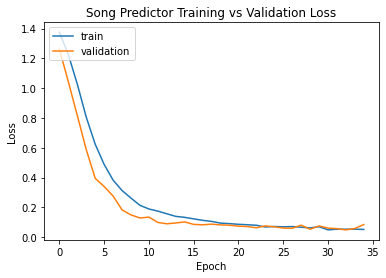

In [16]:
# Training vs Validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Song Predictor Training vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Model for Participant Predictor

Variables

In [17]:
classify = 48

Model Architeture

In [18]:
input = keras.Input(shape = (125, 62, 1),batch_size=(64), name="Input_Layer")

x = layers.Conv2D(kernel_size=(4,4),strides = (2,2), filters=8, activation='Mish',padding="same",name="Layer1")(input)

x = layers.Conv2D(kernel_size=(4,4),strides = (1,1), filters=4, activation='Mish',padding="same",name="Layer2")(x)

x = layers.Conv2D(kernel_size=(2,2),strides = (1,1), filters=4, activation='softmax',padding="same",name="Layer3")(x)

x = layers.Dropout(.25)(x)

x = layers.Conv2D(kernel_size=(2,2),strides = (1,1), filters=16, activation='Mish',padding="same",name="Layer4")(x)

x = layers.Dropout(.25)(x)

x = layers.Flatten()(x)

x = layers.Dense(144,activation="Mish")(x)

x = layers.Dense(26,activation="Mish")(x)

x = layers.Dropout(.26)(x)

x = layers.Dense(105,activation="sigmoid")(x)

x = layers.Dropout(.25)(x)

x = layers.Dense(62,activation="Mish")(x)

x = layers.Dropout(.25)(x)

x = layers.Dense(145,activation="Mish")(x)

x = layers.Dense(classify, activation="softmax", name="Output_Layer")(x)

participant_classifier = keras.Model(input, x, name="Summary")

participant_classifier.summary()

Model: "Summary"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(64, 125, 62, 1)]        0         
                                                                 
 Layer1 (Conv2D)             (64, 63, 31, 8)           136       
                                                                 
 Layer2 (Conv2D)             (64, 63, 31, 4)           516       
                                                                 
 Layer3 (Conv2D)             (64, 63, 31, 4)           68        
                                                                 
 dropout_8 (Dropout)         (64, 63, 31, 4)           0         
                                                                 
 Layer4 (Conv2D)             (64, 63, 31, 16)          272       
                                                                 
 dropout_9 (Dropout)         (64, 63, 31, 16)          0   

Compile Layers

In [19]:
participant_classifier.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

Fit Model

In [20]:
history = participant_classifier.fit(x=x_train, y=y_train_participants, batch_size=64, epochs=25, validation_data = (x_val, y_val_participants))

Epoch 1/25
243/243 [==============================] - 112s 459ms/step - loss: 3.7764 - categorical_accuracy: 0.0393 - val_loss: 3.4156 - val_categorical_accuracy: 0.0840
Epoch 2/25
243/243 [==============================] - 110s 452ms/step - loss: 2.9922 - categorical_accuracy: 0.1467 - val_loss: 2.3478 - val_categorical_accuracy: 0.2586
Epoch 3/25
243/243 [==============================] - 110s 453ms/step - loss: 2.1408 - categorical_accuracy: 0.3043 - val_loss: 1.6863 - val_categorical_accuracy: 0.4255
Epoch 4/25
243/243 [==============================] - 110s 452ms/step - loss: 1.6403 - categorical_accuracy: 0.4216 - val_loss: 1.3437 - val_categorical_accuracy: 0.5422
Epoch 5/25
243/243 [==============================] - 110s 452ms/step - loss: 1.3016 - categorical_accuracy: 0.5138 - val_loss: 1.1608 - val_categorical_accuracy: 0.6220
Epoch 6/25
243/243 [==============================] - 110s 453ms/step - loss: 1.0989 - categorical_accuracy: 0.5787 - val_loss: 0.9582 - val_categoric

Test Model

In [21]:
test_loss, test_acc = participant_classifier.evaluate(x_test, y_test_participants, batch_size= 64)
print('Test Results', '\n', 'Test Accuarcy: ',test_acc,'\n', 'Test Loss: ', test_loss)

243/243 [==============================] - 30s 123ms/step - loss: 0.2679 - categorical_accuracy: 0.9532
Test Results 
 Test Accuarcy:  0.9531893134117126 
 Test Loss:  0.26790931820869446


Visualize Performance

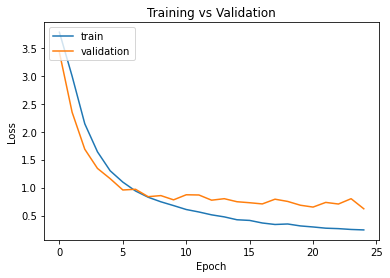

In [22]:
# Training vs Validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()